# Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as gm

## Load Dataset

In [2]:
gm_df = gm.load_game_matchup_dataset()

## Experiment using TimeSeriesSplit

### Specific imports

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

### Dataset

Usando max_split en TimeSeriesSplit permite dividir el dataset por cantidad de filas por lo que vamos a escoger 
solo las temporadas que tiene la misma cantiadad de partidos.


In [4]:
gm_df.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a qu la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [5]:
df = gm_df[gm_df.SEASON >= 2013]

Prueba de como seran dividido el dataset usando TimeSeriesSplit

In [6]:
tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
print(len(X))
for train_index, test_index in tscv.split(X=X):
    print("TRAIN:", train_index, "TEST:", test_index)

7380
TRAIN: [   0    1    2 ... 1227 1228 1229] TEST: [1230 1231 1232 ... 2457 2458 2459]
TRAIN: [1230 1231 1232 ... 2457 2458 2459] TEST: [2460 2461 2462 ... 3687 3688 3689]
TRAIN: [2460 2461 2462 ... 3687 3688 3689] TEST: [3690 3691 3692 ... 4917 4918 4919]
TRAIN: [3690 3691 3692 ... 4917 4918 4919] TEST: [4920 4921 4922 ... 6147 6148 6149]
TRAIN: [4920 4921 4922 ... 6147 6148 6149] TEST: [6150 6151 6152 ... 7377 7378 7379]


### Algorithms 

In [7]:
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))) 
models.append(('SVM', SVC(kernel = 'linear', random_state=0))) 
models.append(('KSVM', SVC(kernel = 'rbf', random_state=0))) 
models.append(('NB', GaussianNB())) 
models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=0))) 
models.append(('SGD', SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)))
models.append(("RF", RandomForestClassifier(n_estimators=500, 
                                            max_features="sqrt", 
                                            max_depth=15, 
                                            n_jobs=-1, 
                                            random_state = 0)))
models.append(("GB", GradientBoostingClassifier(n_estimators=500, 
                                                max_depth=15, 
                                                max_features="sqrt", 
                                                random_state = 0)))

### Run experiments

In [8]:
# Evaluate each model in turn
results = []
names = []
train_splits = len(df.SEASON.unique())-1
print("Start experiment using TimeSeriesSplit")
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=train_splits, max_train_size=1230)
    X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])

    cv_results = cross_validate(model,
                                 X,
                                 y.ravel(),
                                 cv=tscv,
                                 scoring=['balanced_accuracy', 'precision', "recall"]
                                , return_train_score=True
                               )
    
    print(f'{name}')
    print(f'test_balanced_accuracy: {cv_results["test_balanced_accuracy"].mean()} - {cv_results["test_balanced_accuracy"].std()}')
    print(f'test_precision: {cv_results["test_precision"].mean()} - {cv_results["test_precision"].std()}')
    print(f'test_recall: {cv_results["test_recall"].mean()} - {cv_results["test_recall"].std()}')
    cv_results["model"] = [name]*train_splits
    cv_results["season_train"] = df.SEASON.unique()[:-1]
    results.append(cv_results)
    
    names.append(name)
print("Done")

Start experiment using TimeSeriesSplit
KNN
test_balanced_accuracy: 0.6431431584766828 - 0.011044902539925624
test_precision: 0.6985075762346933 - 0.015369466881248071
test_recall: 0.725884397884669 - 0.011610875451362395
SVM
test_balanced_accuracy: 0.6918412907639078 - 0.018043727327153012
test_precision: 0.7466810172745897 - 0.03840415256056668
test_recall: 0.7447854534856809 - 0.06619650569084023
KSVM
test_balanced_accuracy: 0.5 - 0.0
test_precision: 0.583739837398374 - 0.006442800896311838
test_recall: 1.0 - 0.0
NB
test_balanced_accuracy: 0.6687959292399978 - 0.018757661483389473
test_precision: 0.7380109670578745 - 0.019009273040809183
test_recall: 0.6729267214157584 - 0.02847451546759029
DT
test_balanced_accuracy: 0.6073922878353324 - 0.009965590925603557
test_precision: 0.6812463421086008 - 0.01913838605703104
test_recall: 0.6290346589408855 - 0.03845234692203216
SGD
test_balanced_accuracy: 0.5345794450893295 - 0.025199673106387325
test_precision: 0.650885521840929 - 0.1129255567

In [9]:
results_df = pd.DataFrame(results[0])
for idx, result in enumerate(results[1:]):
    result_df = pd.DataFrame(result)
    results_df = pd.concat([results_df, result_df], ignore_index=True)
results_df.to_pickle("./experiments/tscv_exp.pkl")

### Visualize experiments results

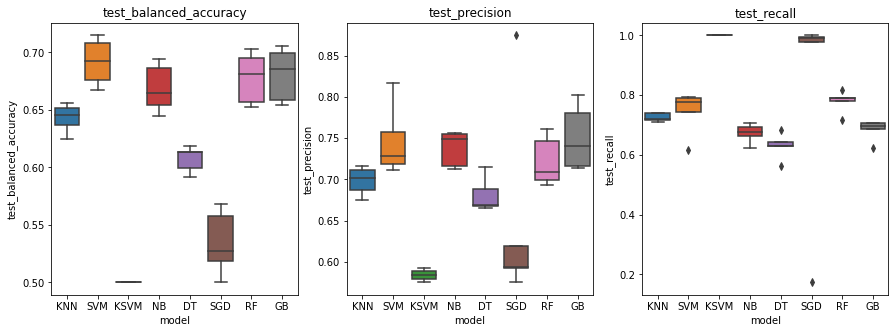

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax=sns.boxplot(x="model", y="test_balanced_accuracy", data=results_df, ax=ax1).set_title("test_balanced_accuracy")
ax= sns.boxplot(x="model", y="test_precision", data=results_df, ax=ax2).set_title("test_precision")
ax=sns.boxplot(x="model", y="test_recall", data=results_df, ax=ax3).set_title("test_recall")

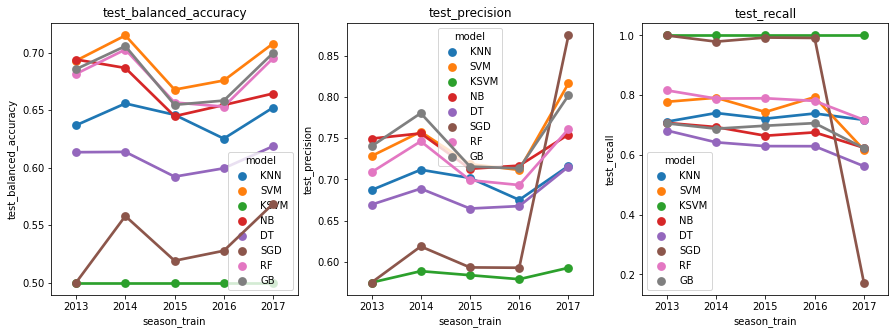

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax = sns.pointplot(data=results_df,
            kind="point", x="season_train", y="test_balanced_accuracy", hue="model", ax=ax1).set_title("test_balanced_accuracy")
ax = sns.pointplot(data=results_df,
            kind="point", x="season_train", y="test_precision", hue="model", ax=ax2).set_title("test_precision")
ax = sns.pointplot(data=results_df,
            kind="point", x="season_train", y="test_recall", hue="model", ax=ax3).set_title("test_recall")
fig.savefig("./plots/tscv_exp.png")

Se observa lo siguiente:

- KSVM: siempre predice true o 1, por esta razon en los graficos podemos ver como para la metrica test_balanced_accuracy mantiene un rendimiento constante de 50%, y sin embargo para la metrica test_recall observamos como muestra tambien un rendimiento constante de 100% acierto, dado que el modelo nunca produce falsos negativos.

- Se observa como los algoritmos mas estables

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Test a specific model

In [12]:
from sklearn.metrics import confusion_matrix

SVC(random_state=0)

Confusion Matrix
[[  0 523]
 [  0 707]]
Test Set: 1230
Accuracy = 57.47967479674797 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

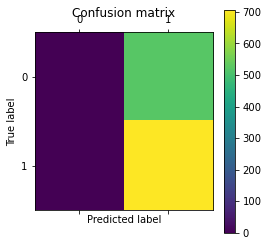

SVC(random_state=0)

Confusion Matrix
[[  0 506]
 [  0 724]]
Test Set: 1230
Accuracy = 58.86178861788618 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

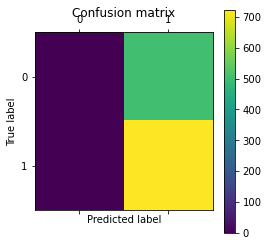

SVC(random_state=0)

Confusion Matrix
[[  0 512]
 [  0 718]]
Test Set: 1230
Accuracy = 58.3739837398374 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

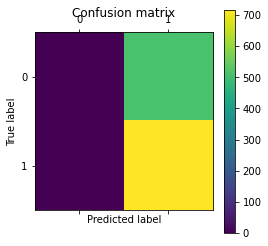

SVC(random_state=0)

Confusion Matrix
[[  0 518]
 [  0 712]]
Test Set: 1230
Accuracy = 57.886178861788615 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

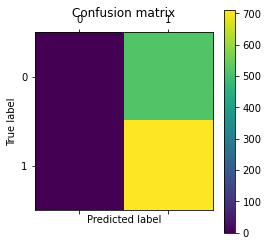

SVC(random_state=0)

Confusion Matrix
[[  0 501]
 [  0 729]]
Test Set: 1230
Accuracy = 59.26829268292683 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

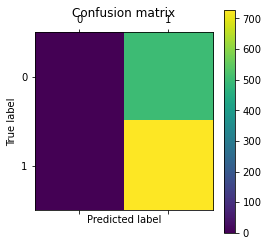

In [13]:
tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
model = SVC(kernel = 'rbf', random_state=0)
for train_index, test_index in tscv.split(X=X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    model.fit(X[train_index], y[train_index].ravel())
    predictions = model.predict(X=X[test_index])
    percentage = model.score(X[test_index], y[test_index].ravel())
    res = confusion_matrix(y[test_index], predictions)
    print("Confusion Matrix")
    print(res)
    print(f"Test Set: {len(X[test_index])}")
    print(f"Accuracy = {percentage*100} %")
    print(f"balanced_accuracy_score: {balanced_accuracy_score(y[test_index], predictions)}")
    print(f"recall_score: {recall_score(y[test_index], predictions)}")
    # Show confusion matrix in a separate window
    plt.matshow(res)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [14]:
results_pred = np.concatenate((predictions.reshape(len(predictions),1), y[test_index].reshape(len(y[test_index]),1)),1)
test_pred = pd.DataFrame(results_pred, columns=["pred", "true"])

### Experiment using StandardScaler

In [15]:
tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
# Evaluate each model in turn
results = []
names = []
train_splits = len(df.SEASON.unique())-1
print("Start scaled experiment using TimeSeriesSplit")
for name, model in models:
    cv_results = {
        "test_balanced_accuracy": [],
        "test_precision": [],
        "test_recall": []
    }
    for train_index, test_index in tscv.split(X=X):
        X[train_index], X[test_index] = utils.feature_scaling(X[train_index], X[test_index], 5)
        fit_info = model.fit(X[train_index], y[train_index].ravel())
        predictions = model.predict(X=X[test_index])
        balanced_accuracy = balanced_accuracy_score(y[test_index], predictions)
        precision = model.score(X[test_index], y[test_index].ravel())
        recall = recall_score(y[test_index], predictions)
        cv_results["test_balanced_accuracy"].append(balanced_accuracy)
        cv_results["test_precision"].append(precision)
        cv_results["test_recall"].append(recall)
    print(f'{name}')
    print(f'test_balanced_accuracy: {np.mean(cv_results["test_balanced_accuracy"])} - {np.std(cv_results["test_balanced_accuracy"])}')
    print(f'test_precision: {np.mean(cv_results["test_precision"])} - {np.std(cv_results["test_precision"])}')
    print(f'test_recall: {np.mean(cv_results["test_recall"])} - {np.std(cv_results["test_recall"])}')
    cv_results["model"] = [name]*train_splits
    cv_results["season_train"] = df.SEASON.unique()[:-1]    
    results.append(cv_results)
    names.append(name)
print("Done")

Start scaled experiment using TimeSeriesSplit
KNN
test_balanced_accuracy: 0.6346307568433254 - 0.0756236167505022
test_precision: 0.631219512195122 - 0.1139750411303325
test_recall: 0.6296022846741206 - 0.3190094437862115
SVM
test_balanced_accuracy: 0.6459694683117553 - 0.07551587754575381
test_precision: 0.6364227642276423 - 0.11578491756114904
test_recall: 0.6013881521935136 - 0.3010627779520948
KSVM
test_balanced_accuracy: 0.5 - 0.0
test_precision: 0.583739837398374 - 0.006442800896311838
test_recall: 1.0 - 0.0
NB
test_balanced_accuracy: 0.6353454928620065 - 0.06977479268839046
test_precision: 0.6182113821138212 - 0.10668773339457031
test_recall: 0.5442085893206183 - 0.2724461512666279
DT
test_balanced_accuracy: 0.5852547013640012 - 0.04168922424950783
test_precision: 0.6089430894308944 - 0.020171778661595443
test_recall: 0.7191963463800155 - 0.11674750370687569
SGD
test_balanced_accuracy: 0.5701304819195422 - 0.08594684694930343
test_precision: 0.5876422764227642 - 0.09877349501830

In [16]:
results_df = pd.DataFrame(results[0])
for idx, result in enumerate(results[1:]):
    result_df = pd.DataFrame(result)
    results_df = pd.concat([results_df, result_df], ignore_index=True)
results_df.to_pickle("./experiments/scaled_tscv_exp.pkl")

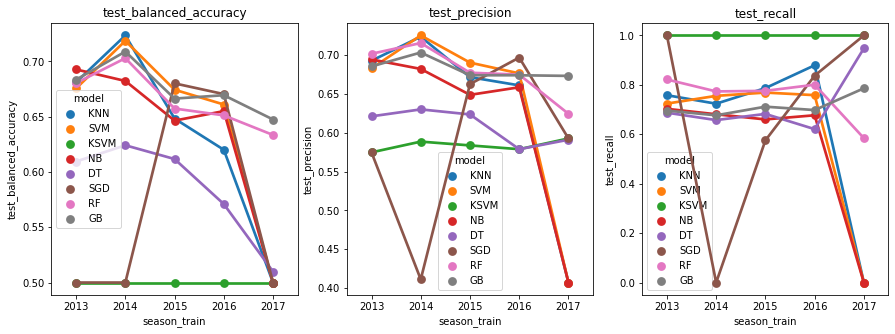

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax = sns.pointplot(data=results_df,
            kind="point", x="season_train", y="test_balanced_accuracy", hue="model", ax=ax1).set_title("test_balanced_accuracy")
ax = sns.pointplot(data=results_df,
            kind="point", x="season_train", y="test_precision", hue="model", ax=ax2).set_title("test_precision")
ax = sns.pointplot(data=results_df,
            kind="point", x="season_train", y="test_recall", hue="model", ax=ax3).set_title("test_recall")
fig.savefig("./plots/scaled_tscv_exp.png")

A partir de realizar los siguientes experimentos:

- Entrenar los modelos sin escalar los valores numericos.

### Experiment using 2 seasons

Usando TimeSeriesSplit visualizaremos como sera dividido el modelo

In [18]:
tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-4, max_train_size=2460)
X, y = train.X_y_values(df, model_config.X_ordinal_cols + model_config.X_num_cols, model_config.y_columns[-1:])
print(len(X))
for train_index, test_index in tscv.split(X=X):
    print("TRAIN:", train_index, "TEST:", test_index)

7380
TRAIN: [   0    1    2 ... 2457 2458 2459] TEST: [2460 2461 2462 ... 4917 4918 4919]
TRAIN: [2460 2461 2462 ... 4917 4918 4919] TEST: [4920 4921 4922 ... 7377 7378 7379]
